<a href="https://colab.research.google.com/github/vinayshanbhag/cloudvisionproductsearch/blob/main/Google_Cloud_Vision_Product_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Google Vision API Product Search allows retailers to create products, each containing reference images that visually describe the product from a set of viewpoints. Retailers can then add these products to product sets. Creation of a product set is covered in [<sup>[1]</sup>](https://github.com/vinayshanbhag/cloudvisionproductsearch/blob/main/Google_Cloud_Vision_Create_a_product_set.ipynb)


When users query the product set with their own images, Vision API Product Search applies machine learning to compare the product in the user's query image with the images in the retailer's product set, and then returns a ranked list of visually and semantically similar results.

We have created a product set of 150 smart devices (phones, speakers, wifi routers, thermostats, cameras etc) [<sup>[Ref]</sup>](https://github.com/vinayshanbhag/cloudvisionproductsearch/blob/main/Google_Cloud_Vision_Create_a_product_set.ipynb)

In this notebook we capture an image of the product using a web cam and query the product set, to identify matching products.

# Installation
Install Google Cloud Vision

`pip3 install -U pip google-cloud-vision`

Restart kernel, if prompted.

In [ ]:
#install google cloud vision
!pip3 install -U pip google-cloud-vision

# Setup

Upload application credentials (key.json) file and set `GOOGLE_APPLICATION_CREDENTIALS` environment variable to point to that file.

In [16]:
# add credentials file "key.json" and set env var
import os
#from IPython.core.display import HTML
#HTML("<script>Jupyter.notebook.kernel.restart()</script>")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/key.json"

Clone product set images from github for quicker local access.

In [ ]:
# clone product images for faster access
!git clone https://github.com/vinayshanbhag/images.git

# Create separate folder for test images
!git clone https://github.com/vinayshanbhag/test_images.git
!rm -rf /content/sample_data/

Sample products in the product set

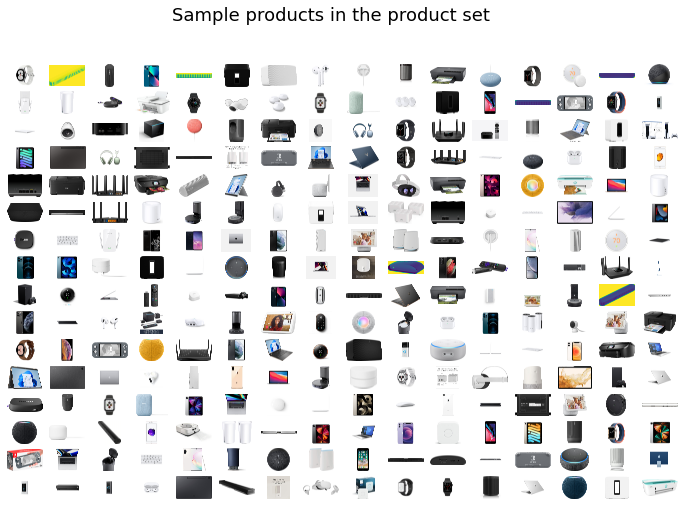

In [30]:
import matplotlib.pyplot as plt
files = [f for f in os.listdir('/content/images') if f.endswith(".jpg")]
nrows = 16
ncols = 16
f, axarr = plt.subplots(nrows, ncols,figsize=(12,8), squeeze=True)
curr_row = 0
for index, row in enumerate(files[:nrows*ncols]):
     col = index % nrows
     if index!=0 and col ==0:
         curr_row += 1
     axarr[col,curr_row].imshow(plt.imread(f"/content/images/{row}"))
     axarr[col,curr_row].set_axis_off()
f.suptitle('Sample products in the product set', fontsize=18);

Project settings...

In [18]:
# Google Vision product search catalog
project_id = 'your_project_id'
location = 'us-west1'
product_set_id = 'your_product_set_id' 
product_category = 'general-v1'
filter = ''

Utility functions to query Google Vision Product Search API and to capture an image from the user's camera.

In [19]:
from google.cloud import vision

# Given a product photo, return matching products in the catalog
def get_similar_products_file(
        project_id, location, product_set_id, product_category,
        file_path, filter):
    """Search similar products to image.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_set_id: Id of the product set.
        product_category: Category of the product.
        file_path: Local file path of the image to be searched.
        filter: Condition to be applied on the labels.
        Example for filter: (color = red OR color = blue) AND style = kids
        It will search on all products with the following labels:
        color:red AND style:kids
        color:blue AND style:kids
    """
    # product_search_client is needed only for its helper methods.
    product_search_client = vision.ProductSearchClient()
    image_annotator_client = vision.ImageAnnotatorClient()

    # Read the image as a stream of bytes.
    with open(file_path, 'rb') as image_file:
        content = image_file.read()

    # Create annotate image request along with product search feature.
    image = vision.Image(content=content)

    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)
    product_search_params = vision.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category],
        filter=filter)
    image_context = vision.ImageContext(
        product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image, image_context=image_context)
    #print(response)
    index_time = response.product_search_results.index_time
    #print('Product set index time: ')
    #print(index_time)

    results = response.product_search_results.results
    ret = []
    for result in results:
        product = result.product
        prd = dict()
        prd['score'] = f"{result.score:.2f}"
        prd['image'] = f'/content/images/{result.image.split("/")[-1]}.jpg'
        prd['product_name'] = product.display_name
        ret.append(prd)
    return ret

# Capture from web cam
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/content/test_images/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Find Matching Products';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Live demo

Capture image from user's web cam*.

Send image to vision API. 

Display results.

*User must grant permission to access device camera.

<IPython.core.display.Javascript object>

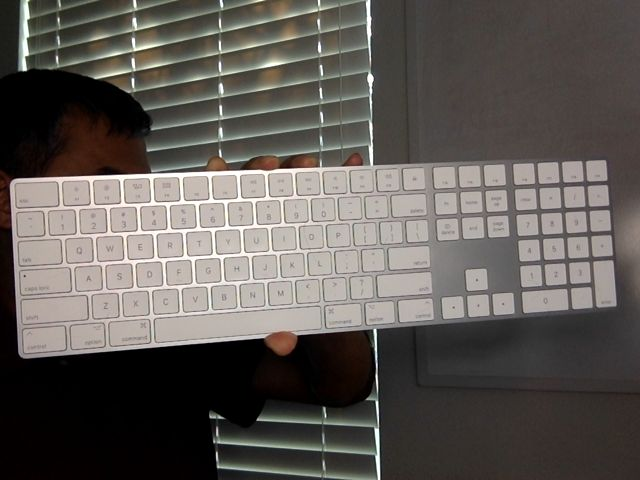

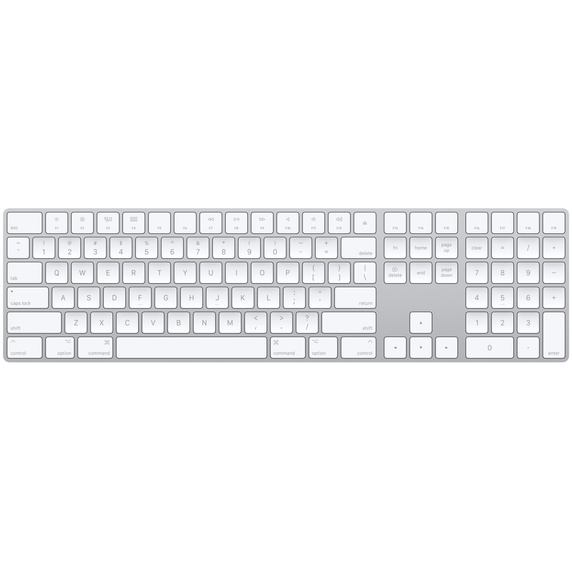

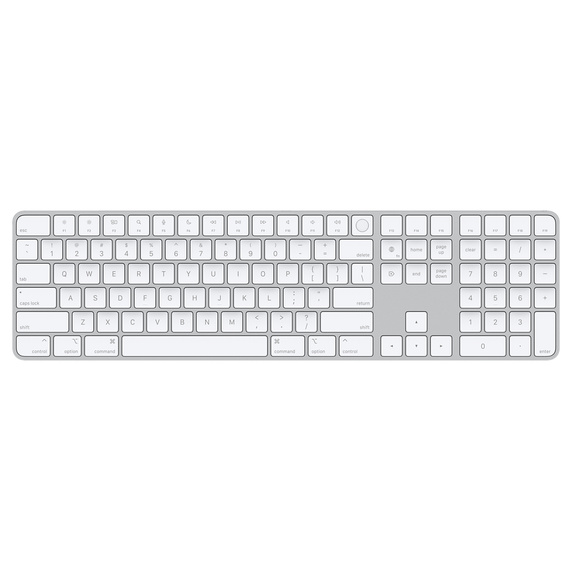

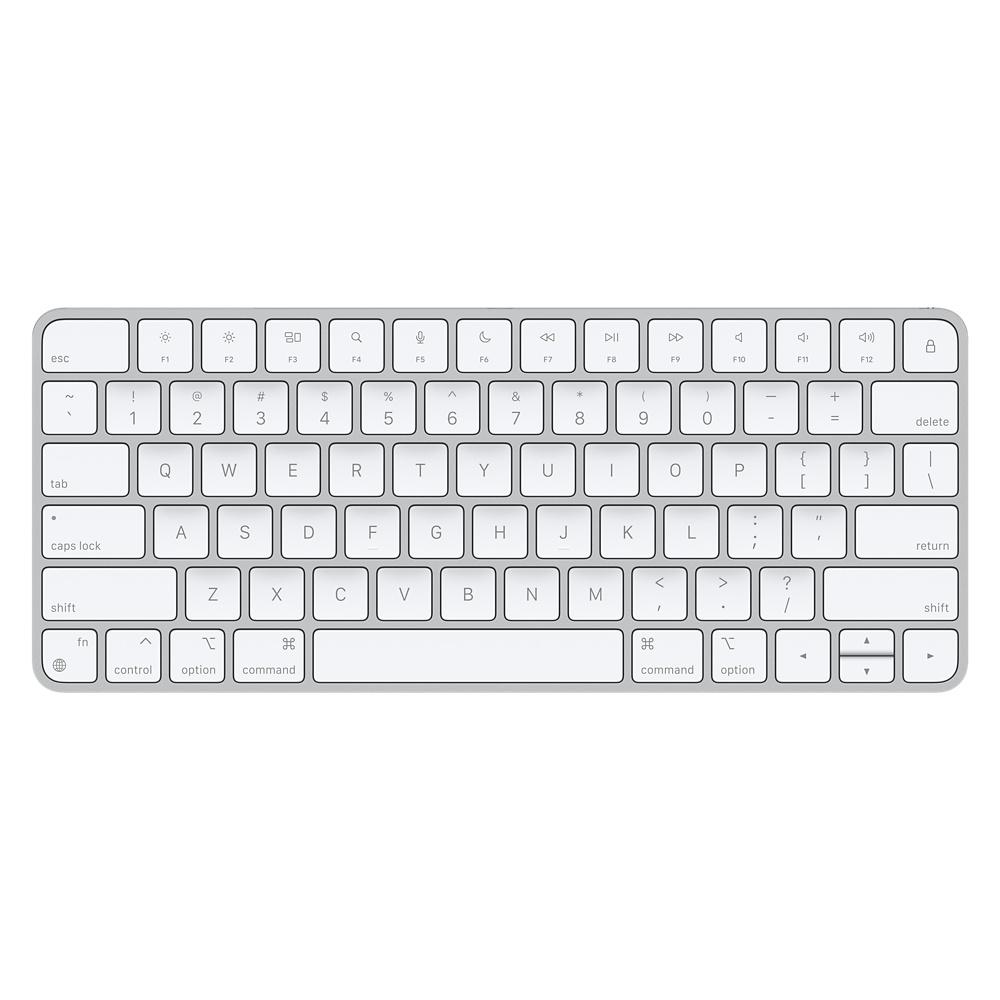

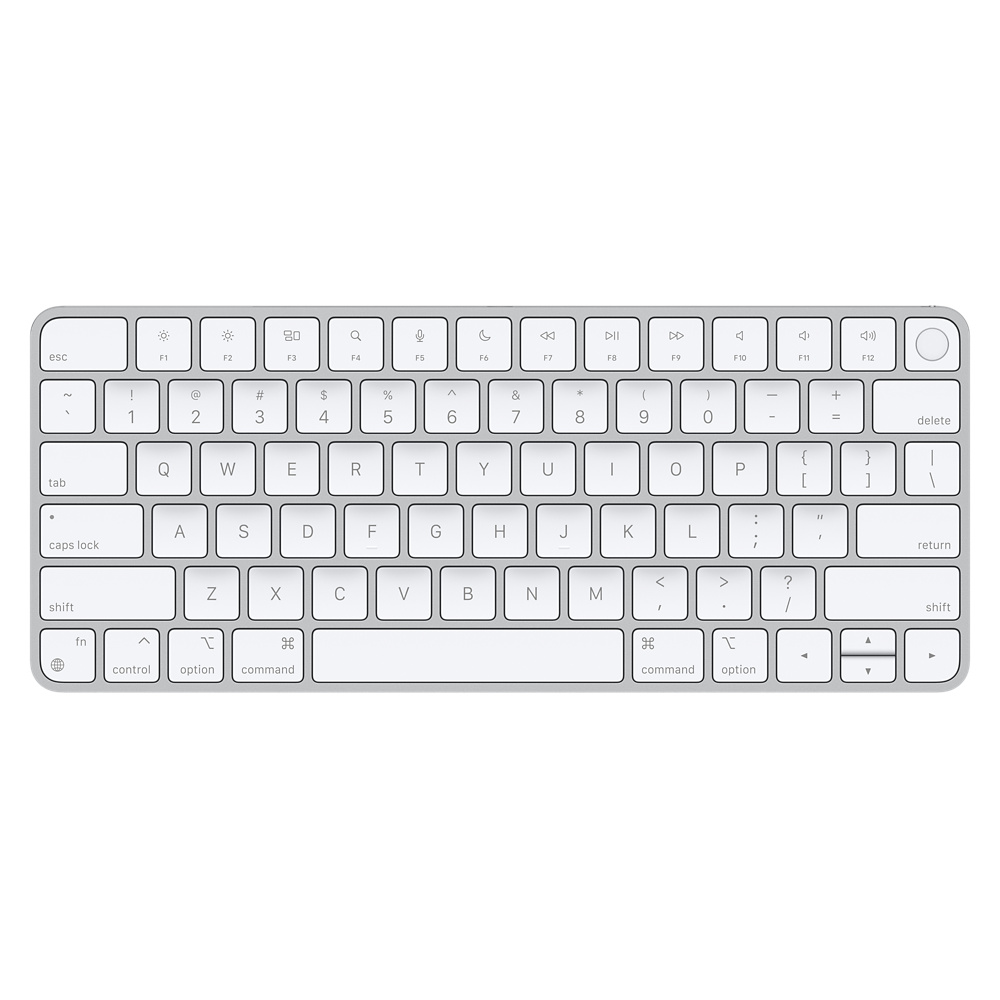

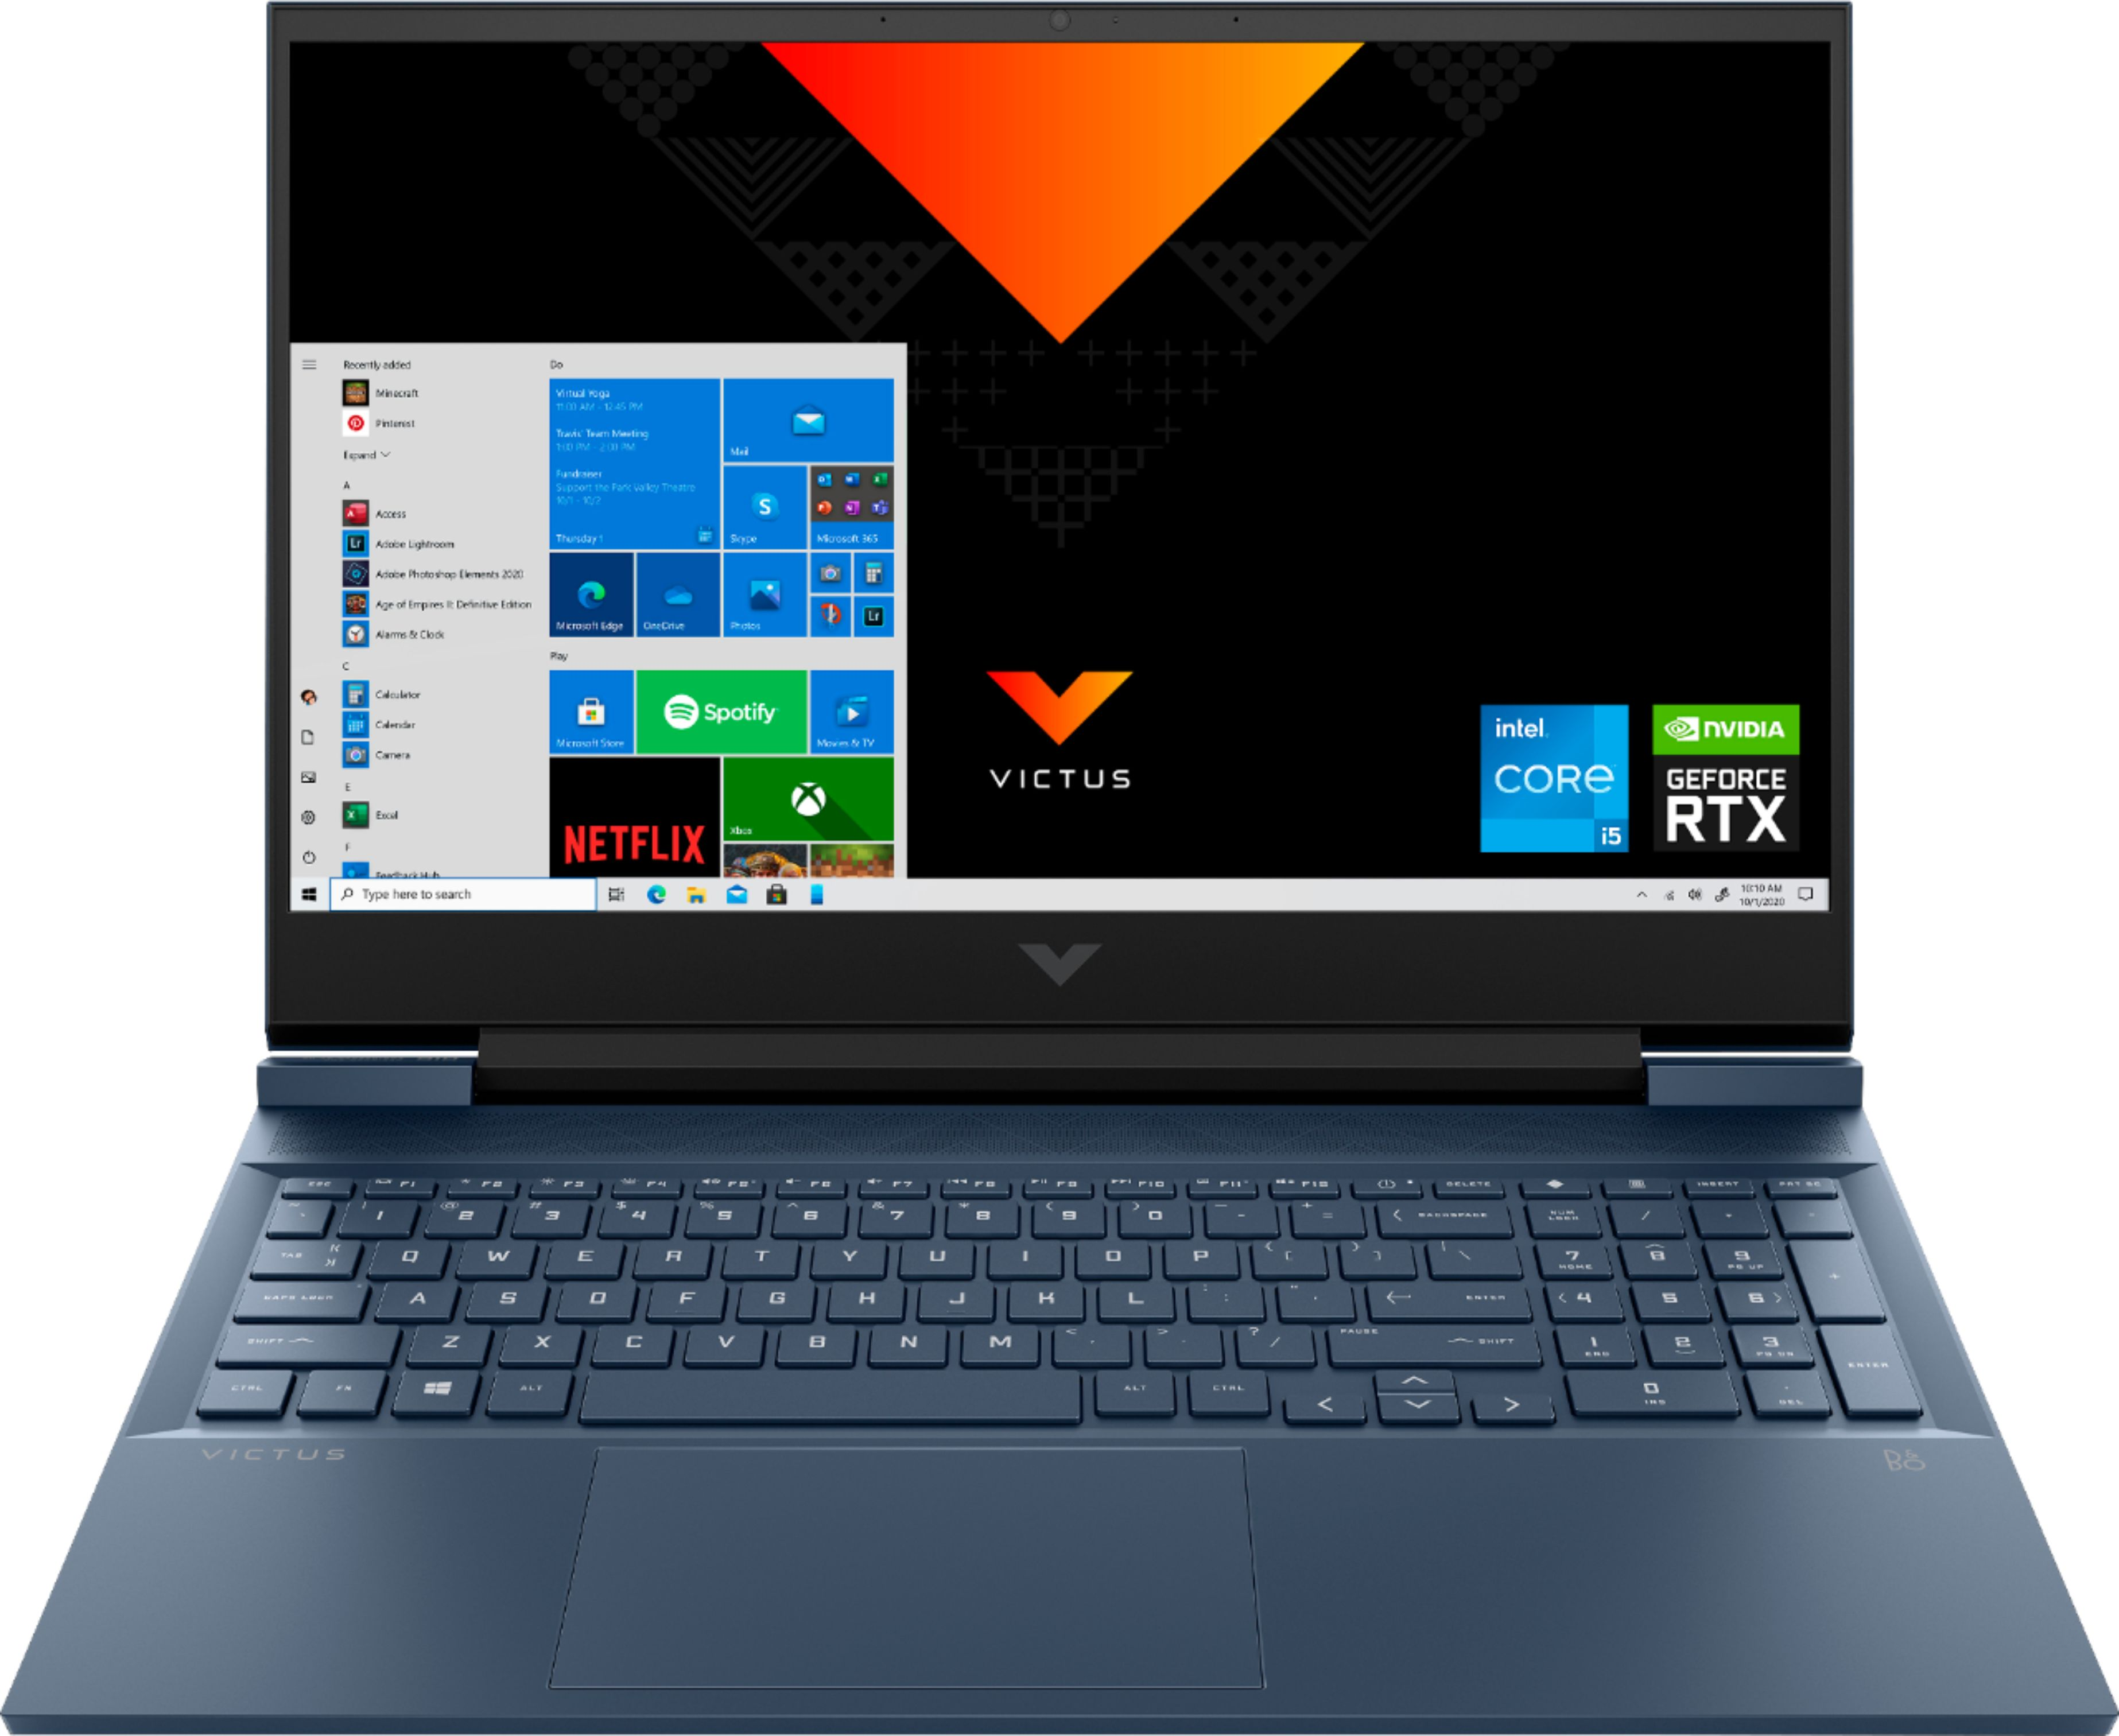

In [ ]:
from IPython.display import display, HTML, Image

try:
  query_image = take_photo() #'/or/path/to/test_image' #
  results = get_similar_products_file(
    project_id,
    location,
    product_set_id, 
    product_category,
    query_image,
    filter
  )
  #print(results)
  display(HTML('<h3>User\'s image of product</h3>'))
  display(Image(query_image, width=250))
  display(HTML('<br><br><h3>Matching products found by Google Vision</h3><br><hr>'))
  for idx, result in enumerate(results[:5]):
    display(HTML(f"<p>{result['product_name']}</p>"))
    display(HTML(f"<p>Score: {result['score']}</p>"))
    if idx==0:display(Image(result['image'], width=250))
    else:display(Image(result['image'], width=50))
    print()
except Exception as err:
  # No webcam or no permission to access web cam
  print(str(err))

# Evaluate accuracy of search results

Search results are evaluated using 50 product images available under `./content/test_images`. `test_products.csv` has the file names and corresponding true class. i.e. the real product in the test image. 
Call Google vision API for each image in the test set and evaluate matched products in the search results against the actual product.


In [20]:
import pandas as pd
df_test = pd.read_csv('/content/test_images/test_products.csv')

In [22]:
df_test['results_raw'] = df_test.filename.apply(lambda x: get_similar_products_file(
    project_id,
    location,
    product_set_id, 
    product_category,
    f"/content/test_images/{x}",
    filter
  ))

In [23]:
for i in range(len(df_test.results_raw.values[0])):
  df_test[f'matched_product_{i}'] = df_test.results_raw.apply(lambda x:x[i]['product_name'])
  df_test[f'score_{i}'] = df_test.results_raw.apply(lambda x:x[i]['score'])


API calls return 10 matching products for each image. Top ranked product is saved under matched_product_0 thru matched_product_9. Save results to a csv file.

In [24]:
df_test.to_csv("test_results.csv", index=None)

In [25]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
def normalize(cnf):
    """
    Returns normalized confusion matrix
    """
    return cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cnf, 
                          labels,
                          norm=False,
                          title='Confusion matrix',
                          colorbar=False,
                          cmap=plt.cm.Blues,
                          xlabel='Predicted Labels',
                          ylabel='True Labels',
                          precision=1
                         ):
    """
    adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting norm=True.
    """
    #plt.figure()
    plt.figure(figsize=(16, 16))
    if norm: 
        cnf = normalize(cnf)
        
    art = plt.imshow(cnf, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=10)
    if colorbar:
        plt.colorbar(art,shrink=0.5).ax.tick_params(labelsize=7) 
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90,fontsize=12)
    plt.yticks(tick_marks, labels,fontsize=12)

    thresh = cnf.max() / 2.
    for i, j in itertools.product(range(cnf.shape[0]), repeat=2):
        if cnf.dtype=='float':
            plt.text(j, i, '{0:0.{1}f}'.format(cnf[i, j],precision),
                 horizontalalignment="center",
                 verticalalignment="center",    
                 fontsize=5,
                 color="white" if cnf[i, j] > thresh else "black")
        else:
            if cnf[i,j]>0:
              plt.text(j, i, cnf[i, j],
                  horizontalalignment="center",
                  verticalalignment="center",    
                  fontsize=10,
                  color="white" if cnf[i, j] > thresh else "black")

    
    plt.ylabel(ylabel,fontsize=18)
    plt.xlabel(xlabel,fontsize=18)
    plt.tight_layout()
    plt.show()

If the actual product appears in any one of the top 3 results from Google Vision Product Search API, we consider it a positive result.

```product_name``` is the true product class

```matched_product_0...3``` are the top 3 predictions

```top3_match``` is true if the true product class appears in any one of the predictions, false otherwise.

In [26]:
df_test['top3_match'] = df_test.apply(lambda x: x['product_name'] in [x['matched_product_0'],x['matched_product_1'],x['matched_product_2']] , axis=1)
df_test[['product_name','top3_match','matched_product_0', 'matched_product_1','matched_product_3']][:5]

,product_name,top3_match,matched_product_0,matched_product_1,matched_product_3
0,Apple Watch Series 3,False,Apple Watch SE,Apple Watch Series 5,Apple Watch Series 3
1,Roku Ultra,True,Roku Ultra 4K,Roku Express HD,Roku Streaming Stick
2,Apple HomePod Mini,True,Apple HomePod Mini,Amazon Echo 2,Amazon Echo Dot 4
3,Canon Pixma Tr4522,True,Canon Pixma Tr4522,Canon Pixma Mg3620,Philips Hue Bridge
4,Sonos Playbar,True,Sonos Playbar,Sonos Beam Gen2,Sonos Arc


Plot classification errors in a confusion matrix.

In [27]:
df_test['top3_match_result']=df_test.apply(lambda x: x['product_name'] if x['top3_match'] else x['matched_product_0'], axis=1)

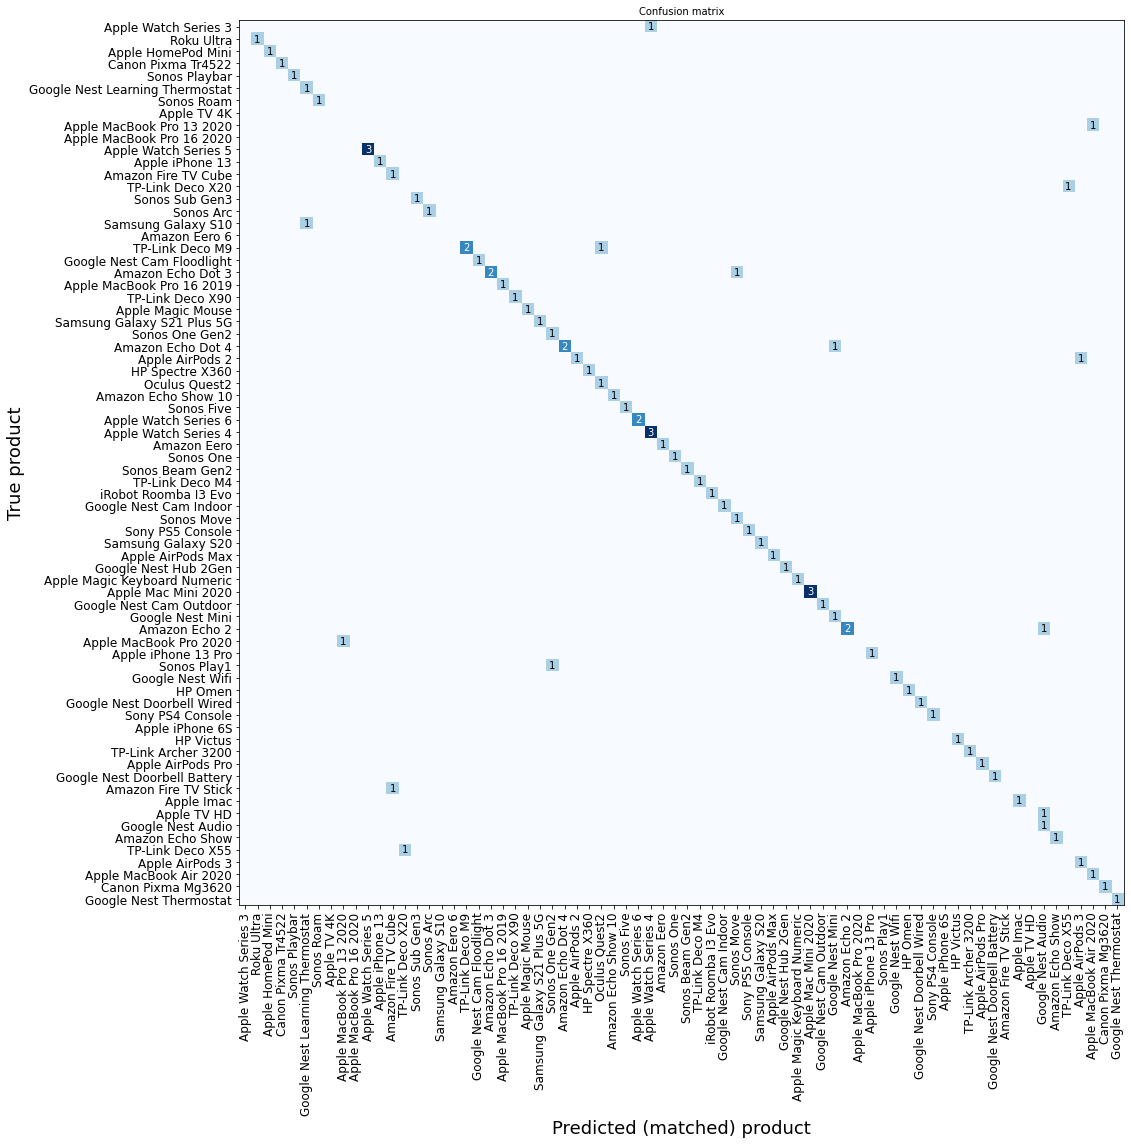

In [28]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(confusion_matrix(df_test.product_name,df_test.top3_match_result, labels=df_test.product_name.unique()), 
                      labels=df_test.product_name.unique(), 
                      norm=False,
                      title='Confusion matrix',
                      xlabel='Predicted (matched) product',
                      ylabel='True product',
                      precision=1
                     );

Precision, recall and F1-score for each product.

In [29]:
from sklearn.metrics import classification_report
print(classification_report(df_test.product_name, df_test.top3_match_result, labels=df_test.product_name.unique()));

                                 precision    recall  f1-score   support

           Apple Watch Series 3       0.00      0.00      0.00         3
                     Roku Ultra       1.00      1.00      1.00         1
             Apple HomePod Mini       1.00      1.00      1.00         1
             Canon Pixma Tr4522       1.00      1.00      1.00         1
                  Sonos Playbar       1.00      1.00      1.00         1
Google Nest Learning Thermostat       0.50      1.00      0.67         1
                     Sonos Roam       1.00      1.00      1.00         1
                    Apple TV 4K       0.00      0.00      0.00         1
      Apple MacBook Pro 13 2020       0.00      0.00      0.00         2
      Apple MacBook Pro 16 2020       0.00      0.00      0.00         1
           Apple Watch Series 5       1.00      1.00      1.00         3
                Apple iPhone 13       1.00      1.00      1.00         1
            Amazon Fire TV Cube       0.50      1.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# References

* Comparison with Auto ML: https://cloud.google.com/vision#section-11
* Quickstart: https://cloud.google.com/vision/product-search/docs/quickstart